# Iris classification with FermionicPQCKernel


<table class="nt-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://MatchCake.github.io/MatchCake/"><img src="https://github.com/MatchCake/MatchCake/blob/main/images/logo/logo_32px.png?raw=true" width=32px height=32px  />Documentation</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/MatchCake/MatchCake/blob/main/tutorials/iris_classification.ipynb"><img src="https://github.com/MatchCake/MatchCake/blob/main/images/logo/colab_logo_32px.png?raw=true" width=32px height=32px  />Run in Google Colab</a>
</td>
  <td>
    <a target="_blank" href="https://github.com/MatchCake/MatchCake/blob/main/tutorials/iris_classification.ipynb"><img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width=32px height=32px />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/MatchCake/MatchCake/blob/main/tutorials/iris_classification.ipynb"><img src="https://github.com/MatchCake/MatchCake/blob/main/images/logo/download_logo_32px.png?raw=true" width=32px height=32px />Download notebook</a>
  </td>
</table>

In this example, you will see how to do data classification with the `FermionicPQCKernel` using the `FixedSizeSVC` model from the MatchCake package. The `FermionicPQCKernel` is a kernel that encode the data into fermionic RXX and fermionic RZZ gates before using fWAP gate to entangle the nearest neighbors qubits together.

# Setup

You can now install the dependencies by running the following commands:

In [ ]:
#@title Install dependencies {display-mode: "form"}

RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

if RunningInCOLAB:
    !git clone https://github.com/MatchCake/MatchCake.git
    %cd MatchCake/
else:
    !pip install -r requirements.txt

!pip install git+https://github.com/MatchCake/MatchCake.git

# Imports

First, we need to import the necessary packages. We will use the `datasets` module from `sklearn` to load the Iris dataset, the `train_test_split` function to split the dataset into training and testing sets, and the `MinMaxScaler` to scale the data. We will also import the `FixedSizeSVC` model from the `matchcake.ml.ml_kernel` module and the `FermionicPQCKernel` from the `matchcake.ml.kernels` module.

In [12]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matchcake.ml.kernels import FermionicPQCKernel
from matchcake.ml.svm import FixedSizeSVC
from matchcake.ml.visualisation import ClassificationVisualizer

# Parameters

We will define our hyperparameters here. We will use 4 qubits to encode the data.

In [13]:
n_qubits = 4

# Load the data

We will load the Iris dataset and scale the data to the range [0, 1].

In [14]:
dataset = datasets.load_iris(as_frame=True)
X, y = dataset.data, dataset.target

In [15]:
X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)

# Split the data

We will split the data into training and testing sets.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Build the model

We will build the model using the `FixedSizeSVC` model and the `FermionicPQCKernel`.

In [17]:
model = FixedSizeSVC(kernel_cls=FermionicPQCKernel, kernel_kwargs=dict(size=n_qubits), random_state=0)

# Train the model

We will train the model using the training data.

In [18]:
model.fit(x_train, y_train)

FixedSizeSVC(kernel_cls=<class 'matchcake.ml.ml_kernel.FermionicPQCKernel'>,
             kernel_kwargs={'size': 4})

# Draw the kernel

We can draw the kernel to visualize the fermionic RXX and RZZ gates.

(<Figure size 900x500 with 1 Axes>, <Axes: >)

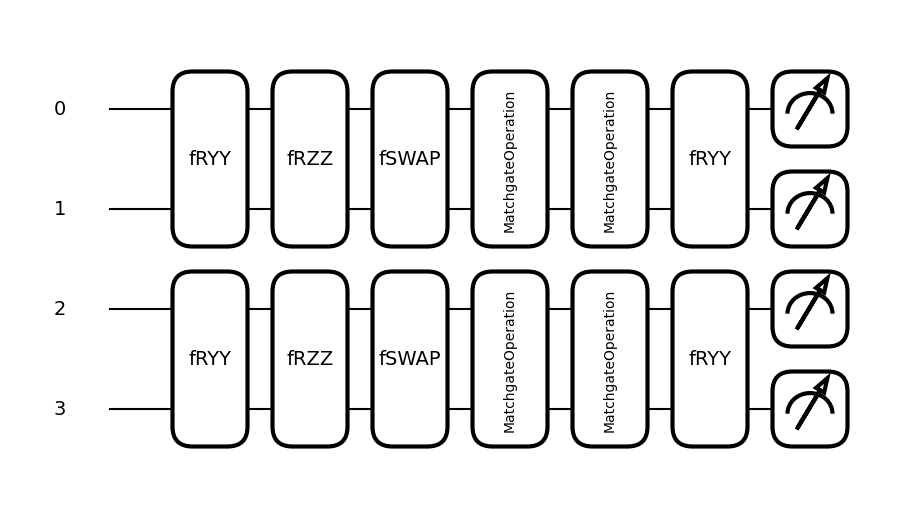

In [19]:
model.kernels[0].draw_mpl()

# Evaluate the model

We will evaluate the model using the testing data.

In [20]:
test_accuracy = model.score(x_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 96.67%


# Visualize the results

We can visualize the decision boundaries of the model.

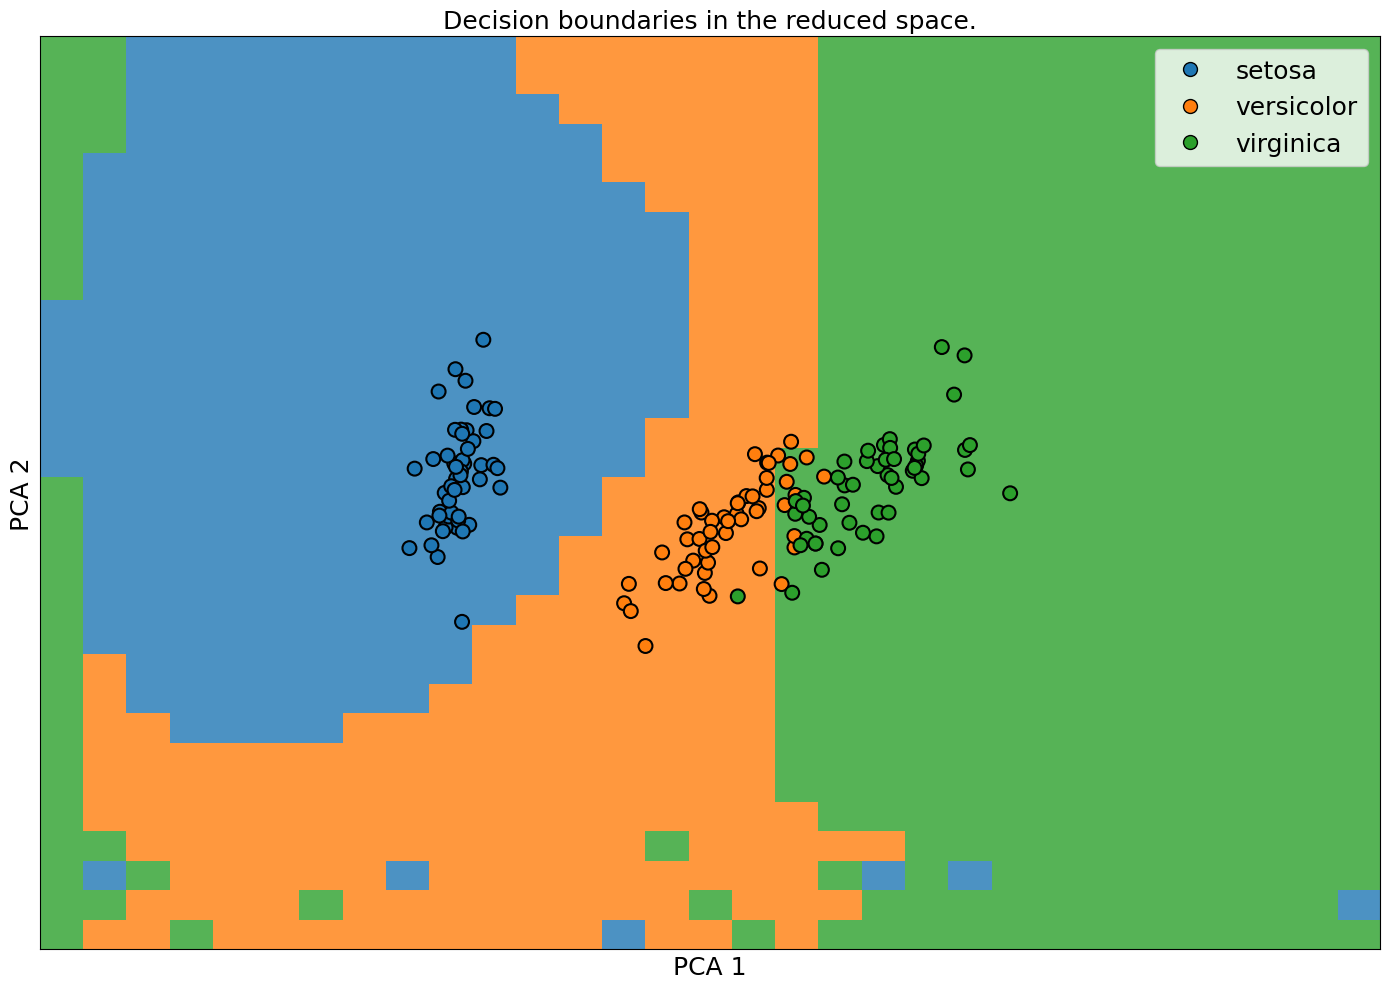

In [21]:
viz = ClassificationVisualizer(x=X, n_pts=1_000)
fig, ax, y_pred = viz.plot_2d_decision_boundaries(
    model=model, y=y, legend_labels=getattr(dataset, "target_names", None), show=True
)